In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-25 15:04:35.735174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 15:04:35.735279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 15:04:35.854979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 15:04:36.117466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 15:04:37.448839: W tensorflow/compiler/tf2

In [2]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


2024-04-25 15:04:40.165026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 15:04:40.165252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 15:04:40.165404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим наши модели:

In [3]:
simple_model = tf.keras.models.load_model('ready_models/simple_model.keras')
inception_v3 = tf.keras.models.load_model('ready_models/inception_v3.keras')
resnet_50_v2 = tf.keras.models.load_model('ready_models/resnet_50_v2.keras')
mobile_net_v2 = tf.keras.models.load_model('ready_models/mobile_net_v2.keras')
xception = tf.keras.models.load_model('ready_models/xception.keras')
nas_net_mobile = tf.keras.models.load_model('ready_models/nas_net_mobile.keras')

simple_model._name = 'simple_model'
inception_v3._name = 'inception_v3'
resnet_50_v2._name = 'resnet_50_v2'
mobile_net_v2._name = 'mobile_net_v2'
xception._name = 'xception'
nas_net_mobile._name = 'nas_net_mobile'

Первая ансамблевая модель - усреднение результата предсказаний:

In [4]:
models = [simple_model, inception_v3, resnet_50_v2, mobile_net_v2, xception, nas_net_mobile]
for model in models:
    model.trainable = False
model_input = tf.keras.Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
x = tf.keras.layers.Concatenate()(model_outputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
model_output = tf.keras.layers.Dense(40, activation='softmax')(x)
ensemble_model_stacked = tf.keras.Model(inputs=model_input, outputs=model_output)

In [5]:
ensemble_model_stacked.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 simple_model (Sequential)   (None, 40)                   7470056   ['input_1[0][0]']             
                                                                                                  
 inception_v3 (Functional)   (None, 40)                   2287239   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 resnet_50_v2 (Functional)   (None, 40)                   2463440   ['input_1[0][0]']         

In [6]:
base_learning_rate = 0.0001
ensemble_model_stacked.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                               loss=tf.keras.losses.CategoricalCrossentropy(),
                               metrics=['accuracy'])

In [7]:
%%time
history = ensemble_model_stacked.fit(train_ds,
                                     epochs=5,
                                     validation_data=val_ds)

Epoch 1/5


2024-04-25 15:06:05.763462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-25 15:06:06.156630: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-25 15:06:13.827623: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-04-25 15:06:19.965088: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller 

433/433 [==============================] - ETA: 0s - loss: 2.9342 - accuracy: 0.7722

2024-04-25 15:10:45.719585: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-25 15:10:45.784973: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


433/433 [==============================] - 301s 614ms/step - loss: 2.9342 - accuracy: 0.7722 - val_loss: 2.2849 - val_accuracy: 0.8325
Epoch 2/5
433/433 [==============================] - 251s 579ms/step - loss: 1.0885 - accuracy: 0.9858 - val_loss: 1.0472 - val_accuracy: 0.8413
Epoch 3/5
433/433 [==============================] - 251s 579ms/step - loss: 0.3214 - accuracy: 0.9885 - val_loss: 0.7526 - val_accuracy: 0.8430
Epoch 4/5
433/433 [==============================] - 251s 580ms/step - loss: 0.1569 - accuracy: 0.9900 - val_loss: 0.6862 - val_accuracy: 0.8403
Epoch 5/5
433/433 [==============================] - 251s 579ms/step - loss: 0.1018 - accuracy: 0.9905 - val_loss: 0.6491 - val_accuracy: 0.8447
CPU times: user 19min 42s, sys: 6min 3s, total: 25min 46s
Wall time: 21min 44s


In [ ]:
ensemble_model_stacked.evaluate(test_ds)

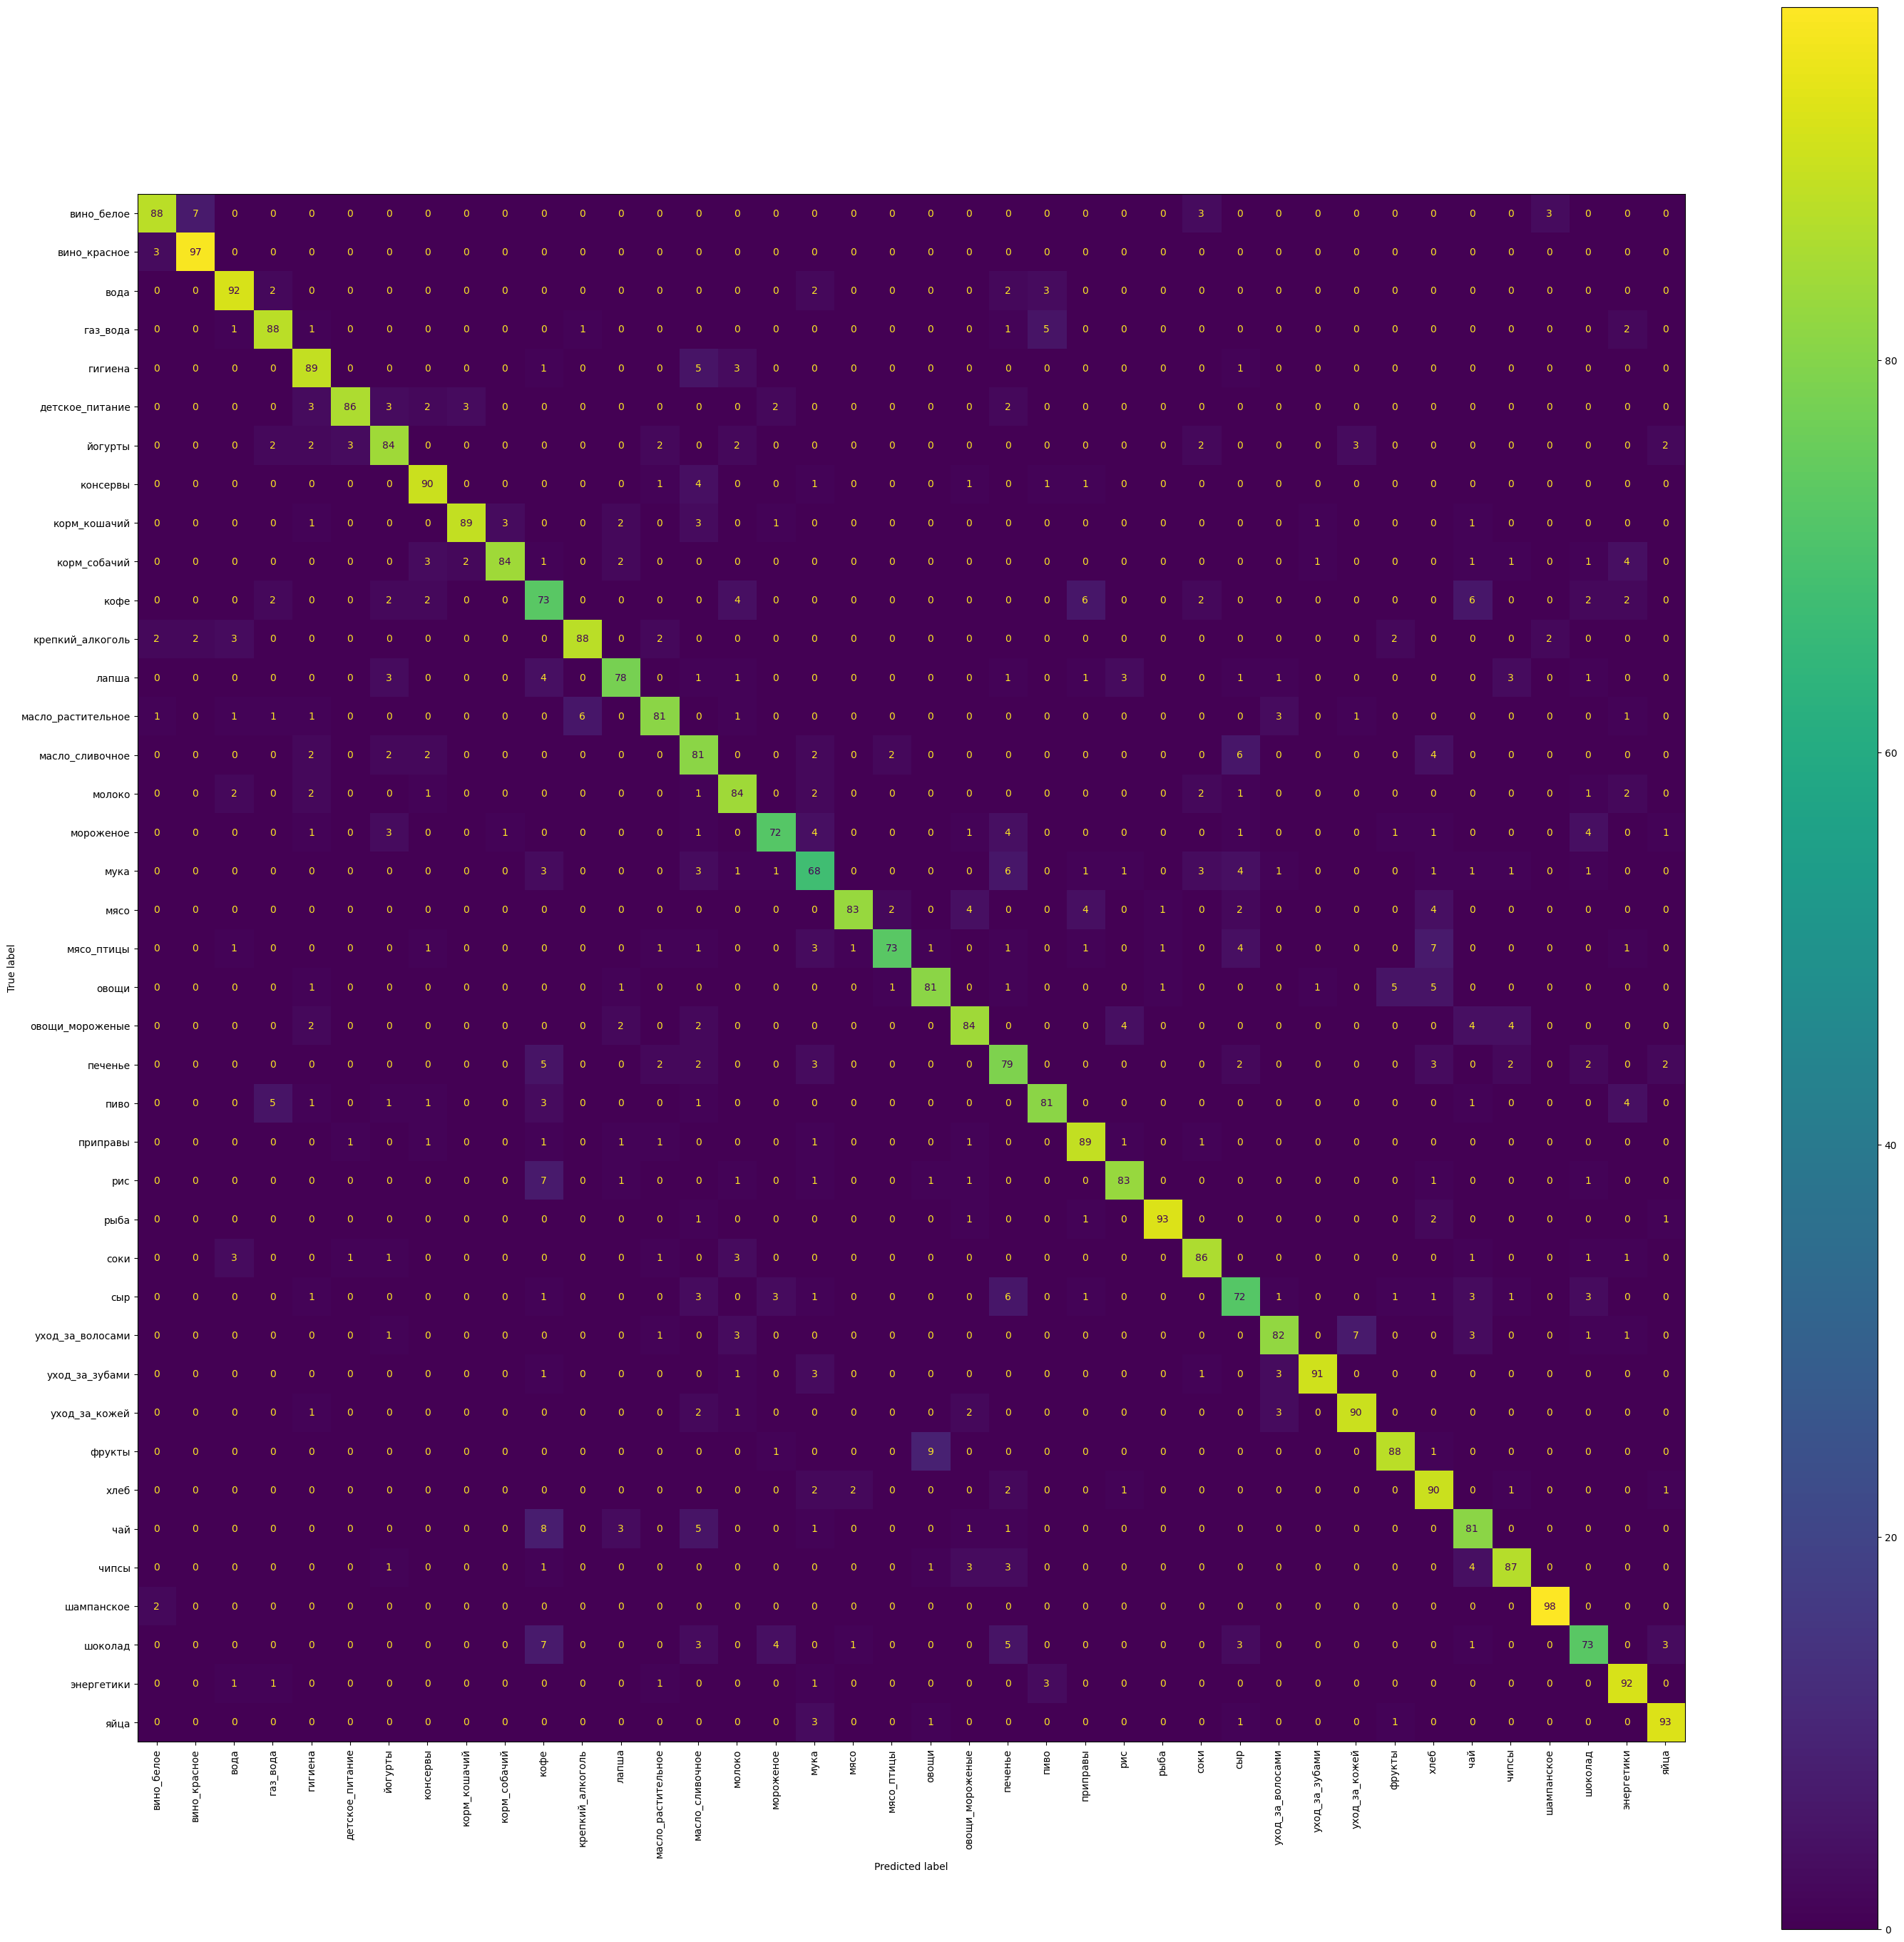

In [10]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(ensemble_model_stacked, test_ds, train_ds.class_names)

In [9]:
ensemble_model_stacked.save('ready_models/ensemble_model_stacked.keras')